#  有沒有用Data augumention訓練模型是否真的有影響
<font size=4> <br>
    這邊我們將拿CIFAR-10的資料來訓練和測試看看Data Augumention對於模型的影響。<br>
    模型部分將組成一個4個卷積層的CNN模型。<br>
    
    
PS: 最後內容有    
- **番外篇1**:我們拿西瓜、蘋果和香蕉的圖片來這兩個模型inference看看。<br>
- **番外篇2**: lr_scheduler是什麼?
    </font>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np
import json
epochs=50
n_batch=64

In [2]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 步驟1. data loader處理 
mytransform_woDA = transforms.Compose([
#             transforms.Resize((28,28)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])


transform_set = [ 
            transforms.RandomCrop(32, padding=4),
            transforms.RandomRotation(degrees=(-15,15)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=(0.8, 1.3), contrast=(
                        0.8, 1.3), saturation=(.8, 1.3), hue=(-0.1, 0.1))
]

    
    
mytransform_wDA = transforms.Compose([
                            transforms.RandomApply(transform_set, p=0.3),
                            transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])


dataset_train_woDA = datasets.CIFAR10(root='./dataset', train=True,
                                        download=False, transform=mytransform_woDA)
dataloader_train_woDA = torch.utils.data.DataLoader(dataset_train_woDA, batch_size=n_batch, num_workers=0, shuffle=True)

dataset_train_wDA = datasets.CIFAR10(root='./dataset', train=True,
                                        download=False, transform=mytransform_wDA)
dataloader_train_wDA = torch.utils.data.DataLoader(dataset_train_wDA, batch_size=n_batch, num_workers=0, shuffle=True)




testset = datasets.CIFAR10(root='./dataset', train=False,
                                       download=False, transform=mytransform_woDA)
testloader = torch.utils.data.DataLoader(testset, batch_size=n_batch,
                                         shuffle=False)

cuda


In [3]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class ConvNet(nn.Module):
    def __init__(self, n_class=3):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            ConvM(3, 32, 5, 2),
            ConvM(32, 32, 5, 2),
            ConvM(32, 32, 3, 1),
            ConvM(32, 32, 3, 1),
        )        
        self.fc = nn.Linear(32, n_class)
    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output

    
    
# initialize the ConvNet
model_wDA = ConvNet(n_class=10).to(device)
model_woDA = ConvNet(n_class=10).to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 步驟4. optimator宣告
optimizer_wDA = optim.SGD(model_wDA.parameters(), lr=0.01, momentum=0.9)
optimizer_woDA = optim.SGD(model_woDA.parameters(), lr=0.01, momentum=0.9)

scheduler_wDA = torch.optim.lr_scheduler.MultiStepLR(optimizer_wDA, milestones=[15,30,45], gamma=0.1)
scheduler_woDA = torch.optim.lr_scheduler.MultiStepLR(optimizer_woDA, milestones=[15,30,45], gamma=0.1)



In [4]:
def evalmodel(model, testloader, loss):
    model.eval()
    test_loss_cnn = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            output_cnn = model(data)
            loss_cnn = loss(output_cnn,target)  
            test_loss_cnn += loss_cnn
            _, predicted = torch.max(output_cnn.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        # the class with the highest energy is what we choose as prediction

    test_loss_cnn /= len(testloader.dataset)
    acc = 100 * correct / total
    return test_loss_cnn, acc

def train(model, optimizer,dataloader_train, dataloader_train_woDA, testloader, loss, total_epoch, scheduler):
    # 步驟5. CNN模型開始訓練
    log_loss_train=[]
    log_loss_test=[]
    
    for epoch in range(total_epoch):
        scheduler.step()
        
        # train
        model.train()
        train_loss_cnn = 0
        for batch_idx, (data, target) in enumerate(dataloader_train):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output_cnn = model(data)
            loss_cnn = loss(output_cnn,target)  
            train_loss_cnn += loss_cnn
            loss_cnn.backward()
            optimizer.step()
        train_loss_cnn /= len(dataloader_train.dataset)
        
    
        if epoch % 5 == 0:
            train_loss, train_acc= evalmodel(model, dataloader_train_woDA, loss)
            test_loss, test_acc= evalmodel(model, testloader, loss)
            
            log_loss_train.append(train_loss)
            log_loss_test.append(test_loss)
            print('learning rate:{}'.format(scheduler.get_last_lr()[0]))
            print('CNN[epoch: [{}/{}], Average loss (Train):{:.5f}, Average loss (test):{:.5f}, acc(train):{:.4f}, acc(test):{:.4f}'.format(
                epoch+1, total_epoch, train_loss, test_loss, train_acc, test_acc))
                      
    print('CNN[epoch: [{}/{}], Average loss (Train):{:.5f}, Average loss (test):{:.5f}, acc(train):{:.4f}, acc(test):{:.4f}'.format(
                epoch+1, total_epoch, train_loss, test_loss, train_acc, test_acc))
    print('training done.')
    return log_loss_train, log_loss_test

In [5]:
print('*'*50)
print('Training with DA')
loss_wDA_train, loss_wDA_test = train(model_wDA, optimizer_wDA, dataloader_train_wDA, dataloader_train_woDA, testloader, loss, total_epoch=epochs, scheduler=scheduler_wDA)


**************************************************
Training with DA
learning rate:0.01
CNN[epoch: [1/50], Average loss (Train):0.02223, Average loss (test):0.02246, acc(train):47.9620, acc(test):47.4000
learning rate:0.01
CNN[epoch: [6/50], Average loss (Train):0.01334, Average loss (test):0.01446, acc(train):69.7520, acc(test):67.0100
learning rate:0.01
CNN[epoch: [11/50], Average loss (Train):0.01094, Average loss (test):0.01272, acc(train):75.3100, acc(test):71.9500
learning rate:0.001
CNN[epoch: [16/50], Average loss (Train):0.00845, Average loss (test):0.01073, acc(train):81.3520, acc(test):76.3300
learning rate:0.001
CNN[epoch: [21/50], Average loss (Train):0.00813, Average loss (test):0.01063, acc(train):82.0680, acc(test):76.5800
learning rate:0.001
CNN[epoch: [26/50], Average loss (Train):0.00779, Average loss (test):0.01044, acc(train):82.9180, acc(test):76.9600
learning rate:0.0001
CNN[epoch: [31/50], Average loss (Train):0.00757, Average loss (test):0.01035, acc(train):83.2

In [6]:
print('*'*50)
print('Training without DA')
loss_woDA_train, loss_woDA_test = train(model_woDA, optimizer_woDA, dataloader_train_woDA, dataloader_train_woDA, testloader, loss, total_epoch=epochs, scheduler=scheduler_woDA)


**************************************************
Training without DA
learning rate:0.01
CNN[epoch: [1/50], Average loss (Train):0.02089, Average loss (test):0.02122, acc(train):50.8200, acc(test):49.6700
learning rate:0.01
CNN[epoch: [6/50], Average loss (Train):0.01271, Average loss (test):0.01444, acc(train):70.9440, acc(test):67.3700
learning rate:0.01
CNN[epoch: [11/50], Average loss (Train):0.01058, Average loss (test):0.01385, acc(train):76.2120, acc(test):69.0700
learning rate:0.001
CNN[epoch: [16/50], Average loss (Train):0.00690, Average loss (test):0.01137, acc(train):85.3160, acc(test):75.1600
learning rate:0.001
CNN[epoch: [21/50], Average loss (Train):0.00641, Average loss (test):0.01156, acc(train):86.3800, acc(test):74.9200
learning rate:0.001
CNN[epoch: [26/50], Average loss (Train):0.00605, Average loss (test):0.01181, acc(train):87.0560, acc(test):74.4900
learning rate:0.0001
CNN[epoch: [31/50], Average loss (Train):0.00574, Average loss (test):0.01189, acc(train):8

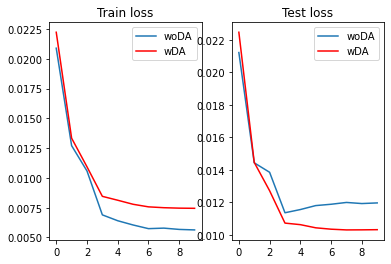

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(loss_woDA_train)
plt.plot(loss_wDA_train,'r')
plt.legend(['woDA','wDA'])
plt.title('Train loss')
plt.subplot(1,2,2)
plt.plot(loss_woDA_test)
plt.plot(loss_wDA_test,'r')
plt.legend(['woDA','wDA'])
plt.title('Test loss')
plt.show()


# 結論
<font size=4>
從上面的結果可以看到，有加Data Augmentation的結果，雖然Training loss或是accuracy都比沒有加Data Augmentation的差，但是在Test dataset的結果，有加Data Augmentation的結果不論在loss或是正確率都比較好。<br>
所以雖然training loss降很低，有可能是overfitting在Train set的分布上，在一般性(Generalization)上沒有比較好。<br>
</font>

<font size=4 color='red'>**所以在訓練程序加上Data Augmentation對於避免模型發生訓練資料overfitting是有幫助的。**</font>


---------------------
# 番外篇1:
<font size=4>
我們拿西瓜、蘋果和香蕉的圖片來這兩個模型inference看看。
    </font>

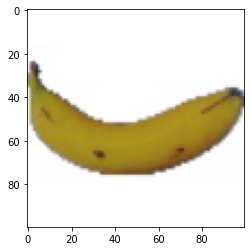

torch.Size([3, 36, 36])
woDA: probability for plane: 28.1733%
woDA: probability for car: 0.6347%
woDA: probability for bird: 4.7854%
woDA: probability for cat: 3.9790%
woDA: probability for deer: 1.0696%
woDA: probability for dog: 1.2028%
woDA: probability for frog: 27.9210%
woDA: probability for horse: 0.0076%
woDA: probability for ship: 32.1408%
woDA: probability for truck: 0.0857%
**************************************************
wDA: probability for plane: 62.3073%
wDA: probability for car: 0.5628%
wDA: probability for bird: 8.5634%
wDA: probability for cat: 11.9968%
wDA: probability for deer: 2.0267%
wDA: probability for dog: 1.8059%
wDA: probability for frog: 4.3810%
wDA: probability for horse: 0.1249%
wDA: probability for ship: 8.0175%
wDA: probability for truck: 0.2136%


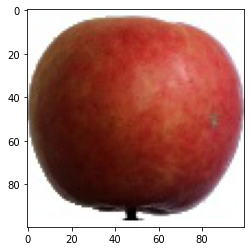

torch.Size([3, 36, 36])
woDA: probability for plane: 1.5595%
woDA: probability for car: 0.0675%
woDA: probability for bird: 53.1154%
woDA: probability for cat: 19.3831%
woDA: probability for deer: 8.0126%
woDA: probability for dog: 8.2460%
woDA: probability for frog: 6.1141%
woDA: probability for horse: 0.1222%
woDA: probability for ship: 3.0530%
woDA: probability for truck: 0.3265%
**************************************************
wDA: probability for plane: 1.4589%
wDA: probability for car: 0.0567%
wDA: probability for bird: 3.1675%
wDA: probability for cat: 85.3407%
wDA: probability for deer: 1.0853%
wDA: probability for dog: 6.3201%
wDA: probability for frog: 2.1261%
wDA: probability for horse: 0.0757%
wDA: probability for ship: 0.1938%
wDA: probability for truck: 0.1753%


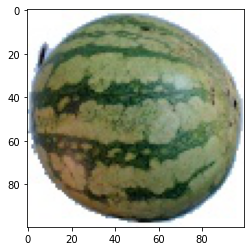

torch.Size([3, 36, 36])
woDA: probability for plane: 3.3105%
woDA: probability for car: 0.1293%
woDA: probability for bird: 18.7271%
woDA: probability for cat: 4.8611%
woDA: probability for deer: 16.8719%
woDA: probability for dog: 3.1213%
woDA: probability for frog: 13.2918%
woDA: probability for horse: 0.4673%
woDA: probability for ship: 38.0512%
woDA: probability for truck: 1.1685%
**************************************************
wDA: probability for plane: 1.0721%
wDA: probability for car: 0.0185%
wDA: probability for bird: 14.8160%
wDA: probability for cat: 26.0165%
wDA: probability for deer: 25.1893%
wDA: probability for dog: 1.9787%
wDA: probability for frog: 30.3773%
wDA: probability for horse: 0.0838%
wDA: probability for ship: 0.3946%
wDA: probability for truck: 0.0533%


In [10]:

mytransform = transforms.Compose([
        transforms.Resize((36,36)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

model_wDA.eval()  
model_woDA.eval()  

#114_100.jpg#
#123_100.jpg#
#r_176_100.jpg#
image_names = ['./dataset/Example_fruit/Test/114_100.jpg',
              './dataset/Example_fruit/Test/123_100.jpg',
              './dataset/Example_fruit/Test/r_176_100.jpg']
for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')
    plt.imshow(image)
    plt.show()
    
    image = mytransform(image)
    print(image.shape)
    with torch.no_grad():
        output_cnn_wDA = model_wDA(torch.unsqueeze(image,dim=0).to(device))
        output_cnn_woDA = model_woDA(torch.unsqueeze(image,dim=0).to(device))
    output_cnn_wDA= F.softmax(output_cnn_wDA)
    output_cnn_woDA= F.softmax(output_cnn_woDA)

    list_class = ['Apple','Banana','Watermelon']
    for i, tmp_out in enumerate(output_cnn_woDA[0]):
        print('woDA: probability for {}: {:.4f}%'.format(classes[i], tmp_out*100))
    print('*'*50)    
    for i, tmp_out in enumerate(output_cnn_wDA[0]):
        print('wDA: probability for {}: {:.4f}%'.format(classes[i], tmp_out*100))

---------------
# 番外篇2: lr_scheduler是什麼?
<font size=4><br>
前面訓練有用到lr_scheduler，這個lr_scheduler是用來調整learning rate的。<br>
    因為神經網路採用梯度下降法在訓練的時候，可能遇到local minima或是learning rate太大無法有效往global minima走。<br>
    所以適度的採用不同的learning rate策略可以舒緩學習不夠收斂一些問題。<br><br>
    * 我們採用lr_scheduler內建函數StepLR和MultiStepLR來和大家說明如何使用此函數。<br>
    - StepLR: 為每step_size步，learning rate就會乘上gamma。<br>
    - MultiStepLR: 設定milestones，只要迭代次數達到設定的值，learning rate就會乘上gamma。<br>
    </font>

In [20]:
optimizer1 = optim.SGD([torch.randn(1, requires_grad=True)], lr=1e-1)
optimizer2 = optim.SGD([torch.randn(1, requires_grad=True)], lr=1e-1)
exp_lr_scheduler_1 = optim.lr_scheduler.StepLR(optimizer1,step_size=7, gamma=0.5)
exp_lr_scheduler_2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=[6,12], gamma=0.5)

for epoch in range(1, 21):
    exp_lr_scheduler_1.step()
    print('Epoch {}, StepLR with stepsize=5, lr: {}'.format(
        epoch, optimizer1.param_groups[0]['lr']))
for epoch in range(1, 21):
    exp_lr_scheduler_2.step()
    print('Epoch {}, MultiStepLR with milestones=[6,12], lr: {}; '.format(
        epoch, optimizer2.param_groups[0]['lr']))

Epoch 1, StepLR with stepsize=5, lr: 0.1
Epoch 2, StepLR with stepsize=5, lr: 0.1
Epoch 3, StepLR with stepsize=5, lr: 0.1
Epoch 4, StepLR with stepsize=5, lr: 0.1
Epoch 5, StepLR with stepsize=5, lr: 0.1
Epoch 6, StepLR with stepsize=5, lr: 0.1
Epoch 7, StepLR with stepsize=5, lr: 0.05
Epoch 8, StepLR with stepsize=5, lr: 0.05
Epoch 9, StepLR with stepsize=5, lr: 0.05
Epoch 10, StepLR with stepsize=5, lr: 0.05
Epoch 11, StepLR with stepsize=5, lr: 0.05
Epoch 12, StepLR with stepsize=5, lr: 0.05
Epoch 13, StepLR with stepsize=5, lr: 0.05
Epoch 14, StepLR with stepsize=5, lr: 0.025
Epoch 15, StepLR with stepsize=5, lr: 0.025
Epoch 16, StepLR with stepsize=5, lr: 0.025
Epoch 17, StepLR with stepsize=5, lr: 0.025
Epoch 18, StepLR with stepsize=5, lr: 0.025
Epoch 19, StepLR with stepsize=5, lr: 0.025
Epoch 20, StepLR with stepsize=5, lr: 0.025
Epoch 1, MultiStepLR with milestones=[6,12], lr: 0.1; 
Epoch 2, MultiStepLR with milestones=[6,12], lr: 0.1; 
Epoch 3, MultiStepLR with milestones=[